In [ ]:
# Project-IE590: Deep Learning for Machine Vision
# Keras Implementation of InceptionV3
# Kristiaan Hector | Varun Aggarwal | Aaron Etienne

In [3]:
# ensures back compatibility
from tensorflow.keras import backend as K

# for reading and preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# inceptionv3 model from keras with pretrained weights
from tensorflow.python.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow as tf

# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
DATASET_PATH  = './weed_data'
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 4
BATCH_SIZE    = 4
NUM_EPOCHS    = 25
WEIGHTS_FINAL = 'model-inception_v3-final_aanis.h5'

In [3]:
# specify data augmentation parameters for training images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/val',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 274 images belonging to 4 classes.
Found 93 images belonging to 4 classes.


In [4]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = cocklebur
Class #1 = foxtail
Class #2 = pigweed
Class #3 = ragweed
****************


In [5]:
# inceptionv4 - model setup
model = InceptionV3(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [6]:
# adding final FC layer at the end of model
x = model.output
x = Flatten()(x)
output_layer = Dense( NUM_CLASSES,
                      activation='softmax',
                      name='softmax')(x)

model = Model(inputs=model.input,
              outputs=output_layer)


# ensure all layers are trainable
for layer in model.layers:
    layer.trainable = True

# setting up optimizer for model
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

batch_normalization_90 (BatchNo (None, 8, 8, 384)    1152        conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_86 (Activation)      (None, 8, 8, 384)    0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 8, 8, 384)    0           batch_normalization_90[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 8, 8, 384)    442368      activation_86[0][0]              
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 8, 8, 384)    442368      activation_86[0][0]              
__________________________________________________________________________________________________
conv2d_91 

In [7]:
# load saved weights
model.load_weights(WEIGHTS_FINAL)

In [8]:
# train the model
hist = model.fit_generator(train_batches,
                           steps_per_epoch=train_batches.samples // BATCH_SIZE,
                           validation_data=valid_batches,
                           validation_steps=valid_batches.samples //
                           BATCH_SIZE,
                           epochs=NUM_EPOCHS)

Epoch 1/25
68/68 [==============================] - 36s 531ms/step - loss: 1.5369 - accuracy: 0.5556 - val_loss: 0.6137 - val_accuracy: 0.7717
Epoch 2/25
68/68 [==============================] - 35s 521ms/step - loss: 0.8182 - accuracy: 0.7778 - val_loss: 0.2351 - val_accuracy: 0.9130
Epoch 3/25
68/68 [==============================] - 36s 523ms/step - loss: 0.7349 - accuracy: 0.7926 - val_loss: 0.5958 - val_accuracy: 0.8370
Epoch 4/25
68/68 [==============================] - 36s 530ms/step - loss: 1.2669 - accuracy: 0.7444 - val_loss: 0.1438 - val_accuracy: 0.9565
Epoch 5/25
68/68 [==============================] - 36s 534ms/step - loss: 0.5927 - accuracy: 0.8741 - val_loss: 0.3007 - val_accuracy: 0.9130
Epoch 6/25
68/68 [==============================] - 36s 526ms/step - loss: 0.7062 - accuracy: 0.8370 - val_loss: 0.2855 - val_accuracy: 0.9348
Epoch 7/25
68/68 [==============================] - 36s 529ms/step - loss: 0.4789 - accuracy: 0.8889 - val_loss: 1.0487 - val_accuracy: 0.8043

In [9]:
# save trained weights
model.save(WEIGHTS_FINAL)

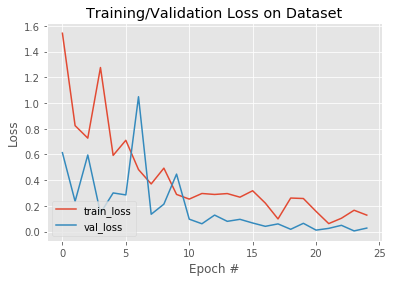

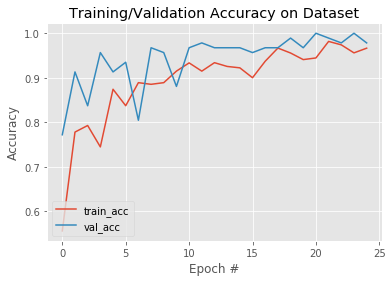

In [10]:
# Plot Results

N=NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")

plt.title("Training/Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot_loss.png")

plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training/Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [8]:
# test model

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                target_size=IMAGE_SIZE,
                                                interpolation='bicubic',
                                                class_mode='categorical',
                                                shuffle=False,
                                                batch_size=1)

out = model.evaluate_generator(test_batches, use_multiprocessing=True)
print(list(zip(model.metrics_names, out)))

Found 91 images belonging to 4 classes.
[('loss', 0.21298317492051846), ('accuracy', 0.95604396)]


In [9]:
test_batches.reset()
Y_pred = model.predict_generator(test_batches, use_multiprocessing=True)
# print(len(Y_pred))

In [10]:
y_pred = np.argmax(Y_pred, axis=1)

print('\n\n Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(list(test_batches.classes), y_pred, target_names=target_names))



 Classification Report

              precision    recall  f1-score   support

   cocklebur       0.86      1.00      0.92         6
     foxtail       0.93      0.93      0.93        14
     pigweed       0.97      1.00      0.99        35
     ragweed       0.97      0.92      0.94        36

    accuracy                           0.96        91
   macro avg       0.93      0.96      0.95        91
weighted avg       0.96      0.96      0.96        91





Confusion Matrix



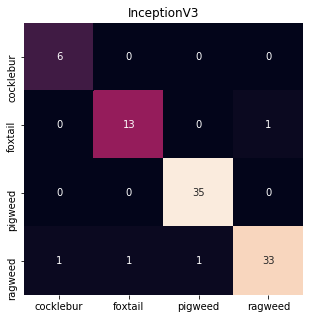

In [11]:
print('\n\nConfusion Matrix\n')
cm = confusion_matrix(test_batches.classes, y_pred)

# row_sums = cm.sum(axis=1)
# cm = cm / row_sums

df_cm = pd.DataFrame(cm,
                     index=['cocklebur', 'foxtail', 'pigweed', 'ragweed'],
                     columns=['cocklebur', 'foxtail', 'pigweed', 'ragweed'])
# print(df_cm)

# flights = df_cm.pivot("month", "year", "passengers")

plt.figure(figsize=(5, 5))
plt.title('InceptionV3')
# sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False)
sn.heatmap(df_cm, annot=True, cbar=False)

plt.savefig('IncepV3.png')